# Numeracy Intervention Analysis File

This file is the companion of the manuscript titled "Numeracy intervention for remedying the impact of school mobility", submitted to the University of Sunderland as assessment of module EDE314 Experiences of Teaching".

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Mapping from concepts to questions in the survey
labels2q = {'Success': (1, 2), 'Interest': (3, 4, 5), 'Utility': (6, 13, 7), 'Mastery': (8, 9), 'Performance': (10, 11)}
# questions that have a reversed scale (1-10)
reverse = 4

df = pd.read_csv('Survey Learning.csv')
questions = list(df.columns.values)
#reverse score of questions with the reversed scale
df.loc[:,questions[reverse]] = 10 - df[[reverse]]

# calculate the total scores for each group concept.
groups = pd.DataFrame()
for name, q in labels2q.items():
    print('Concept {} with {} questions'.format(name, len(q)))
    for qs in q:
        print(questions[qs].rjust(110,'*'))
    totalScore = df[list(q)].sum(axis=1)
    groups[name] = totalScore   

N = int(groups[[0]].count())

Concept Mastery with 2 questions
********The most important thing for me in this course is to understand the content as thoroughly as possible.
****************************************Mastering the material in Introduction to robotics is important to me.
Concept Performance with 2 questions
*******************************************It is important for me to do well compared to others in this class.
********************************************************I just want to avoid getting a low grade in this class
Concept Interest with 3 questions
******************************************************************I think the field of robotics is interesting
*********************************************To be honest, I just don’t find science/engineering interesting
***************************************************I think what we’re learning in this class is interesting.
Concept Success with 2 questions
****************************************************************************I expect to do

In [2]:
# Show the concepts and scores
groups

,Mastery,Performance,Interest,Success,Utility
0,10,7,20,12,15
1,11,11,18,9,17
2,13,14,22,12,19
3,13,12,23,12,21
4,12,2,22,11,18
5,12,12,20,11,19
6,14,11,20,11,17
7,14,14,23,12,21
8,14,14,22,11,18
9,14,7,23,14,21


## Calculate Cronbach's Alpha

Cronbach's alpha ($\alpha$) is also include to assess the consistency of these values under the implicit assumption that the averaged correlation of a set of self-reported values is an accurate estimator of the set of items that belong to a certain construct. A Cronbach's alpha value close to one indicates that the set of values from the survey correspond to the same concept. Conversely, a small $\alpha$ value suggest that the survey has a low number of questions or poor interrelatedness \parencite{tavakol2011making}. $\alpha$ is calculated as follows:
$$\alpha = \frac{K}{K-1} \left(1-\frac{\sum_{i=1}^K \sigma^2_{Y_i}}{ \sigma^2_X}\right)$$

In [3]:
for name, q in labels2q.items():
    sigmaY = df[list(q)].var(axis=0)
    sigmaX = df[list(q)].sum(axis=1).var()
    K = len(q)
    alpha = K/(K-1)*(1-sigmaY.sum()/sigmaX)
    print('Concept: {:15} with Cronbach\' alpha of {:.3}'.format(name,alpha))


Concept: Mastery         with Cronbach' alpha of 0.798
Concept: Performance     with Cronbach' alpha of 0.492
Concept: Interest        with Cronbach' alpha of 0.53
Concept: Success         with Cronbach' alpha of 0.564
Concept: Utility         with Cronbach' alpha of 0.518


## High and low expentancy of success groups

Two diferent groups are considered in here, a groups with low expentancy of success (-1 s.d) and high expentancy of success (+1 s.d).

In [4]:
meanSuccess = groups[['Success']].mean()
sdSuccess = groups[['Success']].std()
lowExpThres = float(np.ceil(meanSuccess - sdSuccess))
highExpThres = float(np.floor(meanSuccess + sdSuccess))

print('Thresholds for low ({}) and high ({}) expentancy groups'.format(lowExpThres, highExpThres))

label = ['' for n in range(N)]
for i, l in enumerate((groups[['Success']] <= lowExpThres).iterrows()):
    if l[1][0]:label[i] = 'low'
for i, h in enumerate((groups[['Success']] >= highExpThres).iterrows()):
    if h[1][0]:label[i] = 'high'

# encode df.famhist as a numeric via pd.Factor
groups['labels'] = pd.Categorical(label)
groups

Thresholds for low (11.0) and high (13.0) expentancy groups


,Mastery,Performance,Interest,Success,Utility,labels
0,10,7,20,12,15,
1,11,11,18,9,17,low
2,13,14,22,12,19,
3,13,12,23,12,21,
4,12,2,22,11,18,low
5,12,12,20,11,19,low
6,14,11,20,11,17,low
7,14,14,23,12,21,
8,14,14,22,11,18,low
9,14,7,23,14,21,high


## Multiple regression with multiplicative interactions and categorical variables

In [37]:
model = smf.ols(formula='Interest ~ Success*label + Performance*label + Mastery*label + Utility*label', data=groups).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Interest   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     67.16
Date:                Sat, 24 Dec 2016   Prob (F-statistic):             0.0953
Time:                        14:50:05   Log-Likelihood:                 22.209
No. Observations:                  15   AIC:                            -16.42
Df Residuals:                       1   BIC:                            -6.506
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                    -9.8205      2.797     -3.511      0.177       -45.361    25.720
label[T.high]                18.8205      4.596      4.095      0.152       -39.575    77.216
label[T.low]                -29.4652      4.327     -6.809      0.093       -84.448    25.517
Success                       1.9161      0.299      6.398      0.099        -1.889     5.721
Success:label[T.high]        -1.9161      0.393     -4.876      0.129        -6.909     3.077
Success:label[T.low]         -6.0590      0.838     -7.230      0.087       -16.707     4.589
Performance                   0.0727      0.176      0.413      0.751        -2.167     2.313
Performance:label[T.high]    -0.0727      0.192     -0.379      0.769        -2.509     2.363
Performance:label[T.low]     -0.6442      0.187     -3.454      0.179        -3.014     1.726
Mastery                      -0.3727      0.493     -0.756      0.588        -6.635     5.889
Mastery:label[T.high]         2.3727      0.652      3.641      0.171        -5.908    10.653
Mastery:label[T.low]          3.8013      0.632      6.016      0.105        -4.227    11.829
Utility                       0.6636      0.119      5.582      0.113        -0.847     2.174
Utility:label[T.high]        -1.3303      0.234     -5.696      0.111        -4.298     1.637
Utility:label[T.low]          3.0506      0.465      6.559      0.096        -2.860     8.961
==============================================================================
Omnibus:                        4.354   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                1.803
Skew:                          -0.676   Prob(JB):                        0.406
Kurtosis:                       4.029   Cond. No.                     2.98e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.67e-35. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Bivariate regression modeling

The multiple regression model describes the score values as a weighted sum of the predictors.The first model correspond to the the two variables Success and Mastery and how they predict the scores is:

$Interest=\beta_0+\beta_1\cdot Success$

In [5]:
est = smf.ols(formula='Interest ~ Success', data=groups).fit()

from IPython.core.display import HTML
def short_summary(est):
    return HTML(est.summary().tables[1].as_html())

short_summary(est)


,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,11.3713,2.965,3.835,0.002,4.966 17.777
Success,0.8366,0.244,3.426,0.005,0.309 1.364


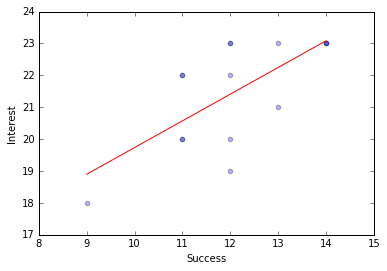

In [6]:
Success_linspace = np.linspace(groups.Success.min(), groups.Success.max(), 100)

plt.xlabel('Success')
plt.ylabel('Interest')
plt.scatter(groups.Success, groups.Interest, alpha=0.3)
plt.plot(Success_linspace, est.params[0] + est.params[1] * Success_linspace, 'r')

## Model \#2:  Prediction of Interest given Performance-approach goals $P(Interest | Performance)$
$Interest=\beta_0+\beta_1\cdot Performance$

In [7]:
est2 = smf.ols(formula='Interest ~ Performance', data=groups).fit()
short_summary(est2)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,20.7383,1.568,13.230,0.000,17.352 24.125
Performance,0.0683,0.141,0.485,0.636,-0.236 0.373


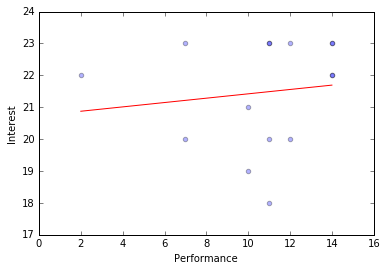

In [8]:
Performance_linspace = np.linspace(groups.Performance.min(), groups.Performance.max(), 100)

plt.xlabel('Performance')
plt.ylabel('Interest')
plt.scatter(groups.Performance, groups.Interest, alpha=0.3)
plt.plot(Performance_linspace, est2.params[0] + est2.params[1] * Performance_linspace, 'r')

## Model \#3:  Prediction of Interest given Mastery-approach goals $P(Interest | Mastery)$
$Interest=\beta_0+\beta_1\cdot Mastery$

In [9]:
est3 = smf.ols(formula='Interest ~ Mastery', data=groups).fit()
short_summary(est3)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,9.7158,3.162,3.072,0.009,2.884 16.547
Mastery,0.9180,0.246,3.734,0.003,0.387 1.449


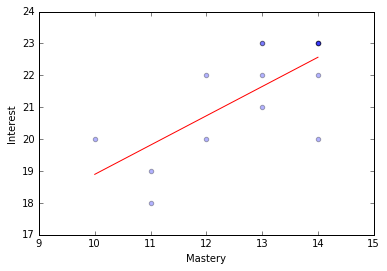

In [10]:
Mastery_linspace = np.linspace(groups.Mastery.min(), groups.Performance.max(), 100)

plt.xlabel('Mastery')
plt.ylabel('Interest')
plt.scatter(groups.Mastery, groups.Interest, alpha=0.3)
plt.plot(Mastery_linspace, est3.params[0] + est3.params[1] * Mastery_linspace, 'r')

## Model \#4: Prediction of Interest given Utility value $P(Interest | Utility)$
$Interest=\beta_0+\beta_1\cdot Utility$

In [11]:
est4 = smf.ols(formula='Interest ~ Utility', data=groups).fit()
short_summary(est4)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,11.5000,2.602,4.420,0.001,5.880 17.120
Utility,0.5320,0.138,3.858,0.002,0.234 0.830


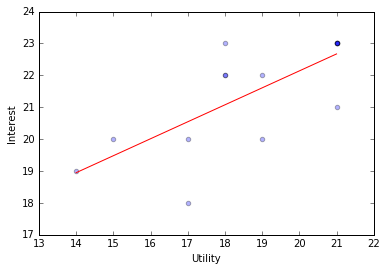

In [12]:
Utility_linspace = np.linspace(groups.Utility.min(), groups.Utility.max(), 100)

plt.xlabel('Utility')
plt.ylabel('Interest')
plt.scatter(groups.Utility, groups.Interest, alpha=0.3)
plt.plot(Utility_linspace, est4.params[0] + est4.params[1] * Utility_linspace, 'r')

## Multiple regression modeling with categorical variables

The multiple regression model describes the score values as a weighted sum of the predictors. Categorical variable $D$ is added to account for two groups in the observed data: a groups with high expectancy of success, and a groups with low expectancy of success. These groups are defined as 1 standard deviation above and below the mean. The regression model under this categorical variable and additive effects is expressed as:  

$$Interest = \beta_0 + \beta_1 Success + \alpha_1 D_1$$

In [13]:
addEst = smf.ols(formula='Interest ~ Success  + label', data=groups).fit()
short_summary(addEst)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,5.0364,7.624,0.661,0.522,-11.744 21.817
label[T.high],-0.9818,1.317,-0.746,0.471,-3.879 1.916
label[T.low],0.9091,1.222,0.744,0.472,-1.780 3.598
Success,1.3636,0.633,2.153,0.054,-0.030 2.758


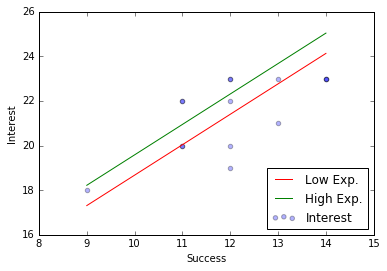

In [14]:
plt.xlabel('Success')
plt.ylabel('Interest')
plt.scatter(groups.Success, groups.Interest, alpha=0.3)
plt.plot(Success_linspace, addEst.params[0] + addEst.params[3] * Success_linspace + addEst.params[2] * 0, 'r',label="Low Exp.")
plt.plot(Success_linspace, addEst.params[0] + addEst.params[3] * Success_linspace + addEst.params[2] * 1, 'g',label="High Exp.")
plt.legend(loc=4)

## Categorical model \#2: Interest given Performance-approach goals $P(Interest|Performance,D=High)$

$$Interest = \beta_0 + \beta_1 Performance + \alpha_1 D_1$$

In [15]:
addEst2 = smf.ols(formula='Interest ~ Performance + label', data=groups).fit()
short_summary(addEst2)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,20.8238,1.641,12.691,0.000,17.212 24.435
label[T.high],1.2404,1.000,1.240,0.241,-0.961 3.442
label[T.low],-0.9292,1.012,-0.919,0.378,-3.156 1.297
Performance,0.0505,0.130,0.389,0.705,-0.236 0.337


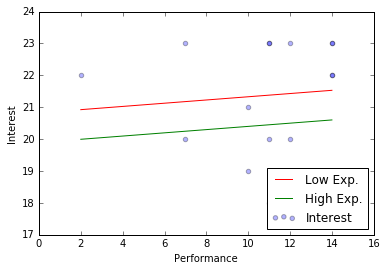

In [16]:
plt.xlabel('Performance')
plt.ylabel('Interest')
plt.scatter(groups.Performance, groups.Interest, alpha=0.3)
plt.plot(Performance_linspace, addEst2.params[0] + addEst2.params[3] * Performance_linspace + addEst2.params[2] * 0, 'r',label="Low Exp.")
plt.plot(Performance_linspace, addEst2.params[0] + addEst2.params[3] * Performance_linspace + addEst2.params[2] * 1, 'g',label="High Exp.")
plt.legend(loc=4)

## Categorical model \#3: Interest given Mastery-approach goals  $P(Interest|Mastery,D=High)$

$$Interest = \beta_0 + \beta_1 Mastery + \alpha_1 D_1$$

In [17]:
addEst3 = smf.ols(formula='Interest ~ Mastery + label', data=groups).fit()
short_summary(addEst3)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,10.8521,3.095,3.507,0.005,4.041 17.663
label[T.high],-0.0104,0.778,-0.013,0.990,-1.722 1.701
label[T.low],-1.3458,0.701,-1.919,0.081,-2.889 0.198
Mastery,0.8646,0.250,3.452,0.005,0.313 1.416


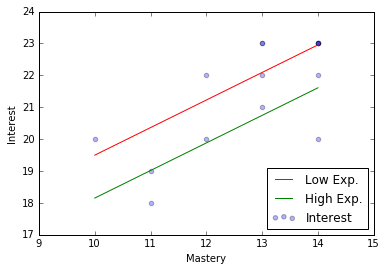

In [18]:
plt.xlabel('Mastery')
plt.ylabel('Interest')
plt.scatter(groups.Mastery, groups.Interest, alpha=0.3)
plt.plot(Mastery_linspace, addEst3.params[0] + addEst3.params[3] * Mastery_linspace + addEst3.params[2] * 0, 'r',label="Low Exp.")
plt.plot(Mastery_linspace, addEst3.params[0] + addEst3.params[3] * Mastery_linspace + addEst3.params[2] * 1, 'g',label="High Exp.")
plt.legend(loc=4)

## Categorical model \#3: Interest given Utility value  $P(Interest|Utility,D=High)$

$$Interest = \beta_0 + \beta_1 Utility + \alpha_1 D_1$$

In [19]:
addEst4 = smf.ols(formula='Interest ~ Utility + label', data=groups).fit()
short_summary(addEst4)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,13.0000,2.988,4.351,0.001,6.424 19.576
label[T.high],0.0800,0.854,0.094,0.927,-1.800 1.960
label[T.low],-0.9067,0.760,-1.194,0.258,-2.579 0.765
Utility,0.4667,0.163,2.858,0.016,0.107 0.826


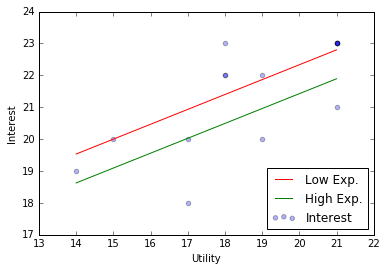

In [20]:
plt.xlabel('Utility')
plt.ylabel('Interest')
plt.scatter(groups.Utility, groups.Interest, alpha=0.3)
plt.plot(Utility_linspace, addEst4.params[0] + addEst4.params[3] * Utility_linspace + addEst4.params[2] * 0, 'r',label="Low Exp.")
plt.plot(Utility_linspace, addEst4.params[0] + addEst4.params[3] * Utility_linspace + addEst4.params[2] * 1, 'g',label="High Exp.")
plt.legend(loc=4)

## Multiple regression modeling with categorical variables and multiplicative effects

The multiple regression model describes the score values as a weighted sum of the predictors. Multiplicative effects are considered in this model as shown below:  

$$Interest = \beta_0 + \beta_1 Success_1 + \alpha_1 D_1 + \alpha_2 (D_1Success_1)$$

In [21]:
mulEst = smf.ols(formula='Interest ~ Success  * label', data=groups).fit()
short_summary(mulEst)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,4.5476,6.357,0.715,0.491,-9.618 18.713
label[T.high],4.4524,11.805,0.377,0.714,-21.850 30.755
label[T.low],-0.0476,7.936,-0.006,0.995,-17.730 17.635
Success,1.4044,0.532,2.638,0.025,0.218 2.590
Success:label[T.high],-0.4044,0.822,-0.492,0.633,-2.236 1.427
Success:label[T.low],0.0956,0.728,0.131,0.898,-1.526 1.717


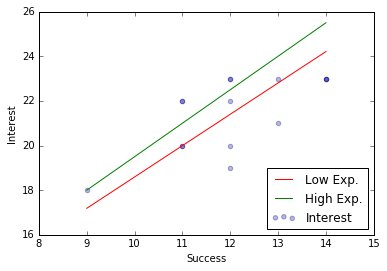

In [22]:
plt.xlabel('Success')
plt.ylabel('Interest')
plt.scatter(groups.Success, groups.Interest, alpha=0.3)
plt.plot(Success_linspace, mulEst.params[0] + mulEst.params[3] * Success_linspace + 
         mulEst.params[2] * 0 + mulEst.params[5] * 0 * Success_linspace, 'r',label="Low Exp.")
plt.plot(Success_linspace, mulEst.params[0] + mulEst.params[3] * Success_linspace + 
         mulEst.params[2] * 1 + mulEst.params[5] * 1 * Success_linspace, 'g',label="High Exp.")
plt.legend(loc=4)

## Model with multiplicative effects \#2: $P(Interest|Performance,D=High)$
$$Interest = \beta_0 + \beta_1 Performance_1 + \alpha_1 D_1 + \alpha_2 (D_1Performance_1)$$

In [23]:
mulEst2 = smf.ols(formula='Interest ~ Performance  * label', data=groups).fit()
short_summary(mulEst2)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,16.1534,2.861,5.647,0.000,9.682 22.625
label[T.high],5.9418,4.240,1.401,0.195,-3.650 15.534
label[T.low],5.4094,3.324,1.627,0.138,-2.110 12.929
Performance,0.4602,0.244,1.883,0.092,-0.093 1.013
Performance:label[T.high],-0.4126,0.378,-1.090,0.304,-1.269 0.443
Performance:label[T.low],-0.5765,0.290,-1.987,0.078,-1.233 0.080


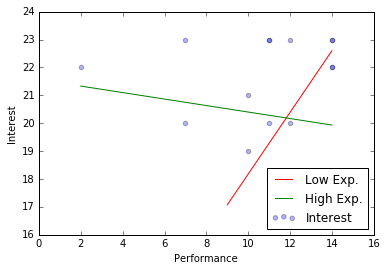

In [24]:
plt.xlabel('Performance')
plt.ylabel('Interest')
plt.scatter(groups.Performance, groups.Interest, alpha=0.3)
plt.plot(Success_linspace, mulEst2.params[0] + mulEst2.params[3] * Performance_linspace + 
         mulEst2.params[2] * 0 + mulEst2.params[5] * 0 * Performance_linspace, 'r',label="Low Exp.")
plt.plot(Performance_linspace, mulEst2.params[0] + mulEst2.params[3] * Performance_linspace + 
         mulEst2.params[2] * 1 + mulEst2.params[5] * 1 * Performance_linspace, 'g',label="High Exp.")
plt.legend(loc=4)

## Model with multiplicative effects \#3: $P(Interest|Mastery,D=High)$
$$Interest = \beta_0 + \beta_1 Mastery_1 + \alpha_1 D_1 + \alpha_2 (D_1Mastery_1)$$

In [25]:
mulEst3 = smf.ols(formula='Interest ~ Mastery  * label', data=groups).fit()
short_summary(mulEst3)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,9.4259,4.459,2.114,0.064,-0.660 19.512
label[T.high],-0.4259,15.470,-0.028,0.979,-35.421 34.569
label[T.low],2.5741,7.177,0.359,0.728,-13.662 18.810
Mastery,0.9815,0.363,2.705,0.024,0.161 1.802
Mastery:label[T.high],0.0185,1.147,0.016,0.987,-2.577 2.614
Mastery:label[T.low],-0.3148,0.574,-0.549,0.597,-1.613 0.983


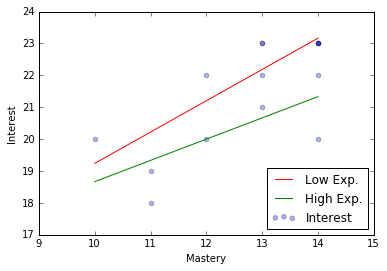

In [26]:
plt.xlabel('Mastery')
plt.ylabel('Interest')
plt.scatter(groups.Mastery, groups.Interest, alpha=0.3)
plt.plot(Mastery_linspace, mulEst3.params[0] + mulEst3.params[3] * Mastery_linspace + 
         mulEst3.params[2] * 0 + mulEst3.params[5] * 0 * Mastery_linspace, 'r',label="Low Exp.")
plt.plot(Mastery_linspace, mulEst3.params[0] + mulEst3.params[3] * Mastery_linspace + 
         mulEst3.params[2] * 1 + mulEst3.params[5] * 1 * Mastery_linspace, 'g',label="High Exp.")
plt.legend(loc=4)

## Model with multiplicative effects \#4: $P(Interest|Utility,D=High)$
$$Interest = \beta_0 + \beta_1 Utility_1 + \alpha_1 D_1 + \alpha_2 (D_1Utility_1)$$

In [27]:
mulEst4 = smf.ols(formula='Interest ~ Utility  * label', data=groups).fit()
short_summary(mulEst4)

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,11.5818,3.209,3.609,0.006,4.323 18.841
label[T.high],14.4182,9.447,1.526,0.161,-6.953 35.790
label[T.low],-6.4390,12.830,-0.502,0.628,-35.463 22.585
Utility,0.5455,0.176,3.101,0.013,0.148 0.943
Utility:label[T.high],-0.7121,0.469,-1.518,0.163,-1.773 0.349
Utility:label[T.low],0.3117,0.719,0.433,0.675,-1.315 1.938


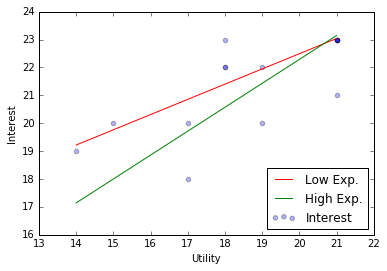

In [28]:
plt.xlabel('Utility')
plt.ylabel('Interest')
plt.scatter(groups.Utility, groups.Interest, alpha=0.3)
plt.plot(Utility_linspace, mulEst4.params[0] + mulEst4.params[3] * Utility_linspace + 
         mulEst4.params[2] * 0 + mulEst4.params[5] * 0 * Utility_linspace, 'r',label="Low Exp.")
plt.plot(Utility_linspace, mulEst4.params[0] + mulEst4.params[3] * Utility_linspace + 
         mulEst4.params[2] * 1 + mulEst4.params[5] * 1 * Utility_linspace, 'g',label="High Exp.")
plt.legend(loc=4)

In [32]:
mulEst3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Interest   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     3.789
Date:                Sat, 24 Dec 2016   Prob (F-statistic):             0.0400
Time:                        14:32:50   Log-Likelihood:                -20.092
No. Observations:                  15   AIC:                             52.18
Df Residuals:                       9   BIC:                             56.43
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 9.4259      4.459      2.114      0.064        -0.660    19.512
label[T.high]            -0.4259     15.470     -0.028      0.979       -35.421    34.569
label[T.low]              2.5741      7.177      0.359      0.728       -13.662    18.810
Mastery                   0.9815      0.363      2.705      0.024         0.161     1.802
Mastery:label[T.high]     0.0185      1.147      0.016      0.987        -2.577     2.614
Mastery:label[T.low]     -0.3148      0.574     -0.549      0.597        -1.613     0.983
==============================================================================
Omnibus:                        0.220   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.896   Jarque-Bera (JB):                0.273
Skew:                           0.228   Prob(JB):                        0.872
Kurtosis:                       2.521   Cond. No.                         738.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""